<div style="padding: 6px 12px 18px 12px; background: #eeffee; border: 2px solid #88aa88; border-radius: 4px;">

<h2>Installing Devito (do not include in manuscipt)</h2>

<p>This tutorial and the coming second part are based on Devito version 3.1.0. It requires the installation of the full software with examples, not only the code generation API. To install:</p>

<pre style="background: #eeffee;">
git clone -b v3.1.0 https://github.com/opesci/devito
cd devito
conda env create -f environment.yml
source activate devito
pip install -e .
</pre>

<p>That final dot is important, don't miss it out!</p>

<h2>Installing Julia</h2>

<p>Users need to install Julia, then the [JUDI] software package v1.0, [JOLI](https://github.com/slimgroup/JOLI.jl), and [SeisIO]. These packages can be downloaded using the Julia package manager. First install Julia 0.6, then start the Julia terminal and do this:</p>

<pre style="background: #eeffee;">
ENV["PYTHON"] = "< PATH TO YOUR ENVS >/devito/bin/python" # e.g. ~/anaconda/envs
Pkg.add("IJulia")
Pkg.add("HDF5")
Pkg.add("PyCall")
Pkg.clone("https://github.com/slimgroup/SeisIO.jl.git")
Pkg.clone("https://github.com/slimgroup/JOLI.jl.git")
Pkg.clone("https://github.com/slimgroup/JUDI.jl.git")
Pkg.checkout("JUDI","tle_tutorial_jan_2018")
</pre>

<h2>Useful links</h2>
<ul>
<li><a href="http://www.opesci.org/">Devito documentation</a></li>
<li><a href="https://github.com/opesci/Devito">Devito source code and examples</a></li>
<li><a href="https://github.com/opesci/Devito/examples/seismic/tutorials">Tutorial notebooks with latest Devito/master</a></li>
</ul>

</div>

### Geophysics tutorial


# Full-Waveform Inversion - Part 3: optimization

Philipp Witte<sup>1</sup>\*, Mathias Louboutin<sup>1</sup>, Keegan Lensink<sup>1</sup>, Michael Lange<sup>2</sup>, Navjot Kukreja<sup>2</sup>, Fabio Luporini<sup>2</sup>, Gerard Gorman<sup>2</sup>, and Felix J. Herrmann<sup>1,3</sup>

<sup>1</sup> Seismic Laboratory for Imaging and Modeling (SLIM), The University of British Columbia 

<sup>2</sup> Imperial College London, London, UK

<sup>3</sup> now at Georgia Institute of Technology, USA 

Corresponding author: pwitte@eoas.ubc.ca

## Introduction

This tutorial is the third part of a full-waveform inversion (FWI) tutorial series with a step-by-step walkthrough of setting up forward and adjoint wave equations and building a basic FWI inversion framework. For discretizing and solving wave equations, we use [Devito], a Python-based domain-specific language for automated generation of finite-difference code (Lange et al., 2016). The first two parts of this tutorial (Louboutin et al., 2017, 2018) demonstrated how to solve the acoustic wave equation for modeling seismic shot records and how to compute the gradient of the FWI objective function using the adjoint-state method. With these two key ingredients, we will now build an inversion framework that can be used to minimize the FWI least-squares objective function.

[Devito]:http://www.opesci.org/devito-public
[Julia]:https://julialang.org
[JUDI]:https://github.com/slimgroup/JUDI.jl/tree/tle_tutorial_jan_2018

FWI is a computationally and mathematically challenging problem. The computational complexity comes from the fact that an already expensive solution procedure for the wave equation needs to be repeated for a large number of source positions for each iteration of the optimization algorithm. The mathematical complexity comes from the fact that the FWI objective is known to have many local minima due to cycle skipping. 

<div style="background: #eeeeee; border: 2px solid gray; border-radius:5px; padding: 6px 10px 6px 10px;">

<h3> NOT FOR MANUSCRIPT</h3>

<p>Furthermore, since the solution is not unique it is generally not possible to unambiguously recover the parameterization of the subsurface from the given data alone, making FWI an active field of research (e.g. Leeuwen et al., 2013; Warner and Guasch, 2014; Peters and Herrmann, 2017).</p>

</div>

This tutorial demonstrates how we can set up a basic FWI framework with two alternative gradient-based optimization algorithms: stochastic gradient descent, and the Gauss–Newton method (Nocedal and Wright, 2009). 

We implement our inversion framework with the [Julia Devito Inversion framework](https://github.com/slimgroup/JUDI.jl/tree/tle_tutorial_jan_2018) (JUDI), a parallel software package for seismic modeling and inversion in the [Julia](Bezanson et al., 2012) programming language. JUDI provides abstractions and function wrappers that allow the implementation of wave-equation-based inversion problems such as FWI using code that closely follows the mathematical notation, while using Devito’s automatic code generation for solving the underlying wave equations.

All the code to run the algorithms and generate the figures in this paper can be found at http://github.com/SEG. 


## Optimizing the FWI objective function

The goal of this tutorial series is to optimize the FWI objective function with the $\ell_2$-misfit:

$$
    \mathop{\hbox{minimize}}_{\mathbf{m}} \hspace{.2cm} f(\mathbf{m})= \sum_{i=1}^{n_s} \frac{1}{2} \left\lVert \mathbf{d}^\mathrm{pred}_i (\mathbf{m}, \mathbf{q}_i) - \mathbf{d}_i^\mathrm{obs} \right\rVert_2^2,
$$

where $\mathbf{d}^\mathrm{pred}_i$ and $\mathbf{d}^\mathrm{obs}_i$ are the predicted and observed seismic shot records of the $i^{\text{th}}$ source location and $\mathbf{m}$ is the velocity model (expressed as squared slowness). In part one, we demonstrated how to implement a forward modeling operator to generate the predicted shot records, which we will denote as $\mathbf{d}^\mathrm{pred}_i = \mathbf{F}(\mathbf{m},\mathbf{q}_i)$. 
In the second tutorial, we then showed how we can compute the gradient $\nabla f(\mathbf{m})$ of the objective function and update our initial model using gradient descent.

There is a snag, however. This first-order optimization algorithm has a linear convergence rate at best, and typically requires many iterations to converge. Second-order optimization methods converge considerably faster. To implement them, we first approximate the objective with a second-order Taylor expansion:

$$
	f(\mathbf{m}) = f(\mathbf{m}_0) + \nabla f(\mathbf{m}_0) \delta \mathbf{m} + \delta \mathbf{m}^\top \nabla^2 f(\mathbf{m}_0) \delta \mathbf{m} + \mathcal{O}(\delta \mathbf{m}^3),
$$

where $\mathcal{O}(\delta \mathbf{m}^3)$ represents the error term, $\nabla f(\mathbf{m}_0)$ is the gradient as implemented in part two, and $\nabla^2 f(\mathbf{m}_0)$ is the Hessian of the objective function, which we will refer to as $\mathbf{H}$. Rather than using the negative gradient to incrementally update our model, as in gradient descent, we directly calculate a model update $\delta \mathbf{m}$ that leads us to the minimum. This is called Newton's method:

$$
	\delta \mathbf{m} = - \mathbf{H}(\mathbf{m}_0)^{-1} \nabla f(\mathbf{m}_0).
$$

Although the method converges to the minimum of the FWI objective function quickly, it comes at the cost of having to compute and invert the Hessian matrix (Nocedal and Wright, 2009). Fortunately, for least squares problems, such as FWI, the Hessian can be approximated by the Gauss-Newton (GN) Hessian $\mathbf{J}^\top \mathbf{J}$, where $\mathbf{J}$ is the Jacobian matrix. This is the partial derivative of the forward modeling operator $\mathbf{F}(\mathbf{m},\mathbf{q})$ with respect to $\mathbf{m}$ — something we can easily compute. Furthermore, the Jacobian can also be used to express the gradient of the FWI objective function as $\nabla f(\mathbf{m}_0) = \mathbf{J}^\top (\mathbf{d}^\mathrm{pred}_i - \mathbf{d}_i^\mathrm{obs})$, where $\mathbf{J}^\top$ is the adjoint (transposed) Jacobian. This is useful, because we now have a set of operators $\mathbf{F}, \mathbf{J}$ and $\mathbf{H}_{GN}=\mathbf{J}^\top\mathbf{J}$, through which we can express both first and second order optimization algorithms for FWI.

Although forming these matrices explicitly is not possible, since they can become extremely large, we only need the action of these operators on vectors. This allows us to implement these operators matrix-free. In the following section we will demonstrate how to set up these operators in our JUDI software framework and to how to use them to implement FWI algorithms.

<div style="background: #eeeeee; border: 2px solid gray; border-radius:5px; padding: 6px 10px 6px 10px;">

<h3> NOT FOR MANUSCRIPT</h3>

<p>[SeisIO]:https://github.com/slimgroup/SeisIO.jl</p>

<p>The Julia Devito Inversion framework is a parallel matrix-free linear operator library for seismic modeling and inversion based on Devito and [SeisIO], a performant Julia package for reading and writing large data volumes in SEG-Y format. JUDI allows implementing seismic inversion algorithms as linear algebra operations, enabling rapid translations of FWI algorithms to executable Julia code. The underlying wave equations are set up and solved using Devito, as described in the first two tutorials, and are interfaced from Julia using the [PyCall](https://github.com/JuliaPy/PyCall.jl) package (Johnson, 2017). </p>

<p>For reading and writing SEG-Y data, JUDI uses the SeisIO package, a sophisticated SEG-Y reader that allows us to scan large 3D data sets for creating look-up tables with header summaries. However, since our data set is relatively small, we will directly load the full file into memory. The `segy_read` command takes the file name as an input and returns a dense data block. This is our observed data and we store it as a JUDI vector.</p>

</div>

In [1]:
# NOT FOR MANUSCRIPT
addprocs(4);

In [2]:
# NOT FOR MANUSCRIPT
using SeisIO
using JUDI.TimeModeling, JUDI.SLIM_optim

## Implementing FWI in JUDI

We start our demonstration by reading our data set, which consists of 16 shot records and was generated with an excerpt from the SEG/EAGE Overthrust model (Aminzadeh et al. 1997). We store it as a `judiVector`:

In [3]:
block = segy_read("overthrust_shot_records.segy")
d_obs = judiVector(block);

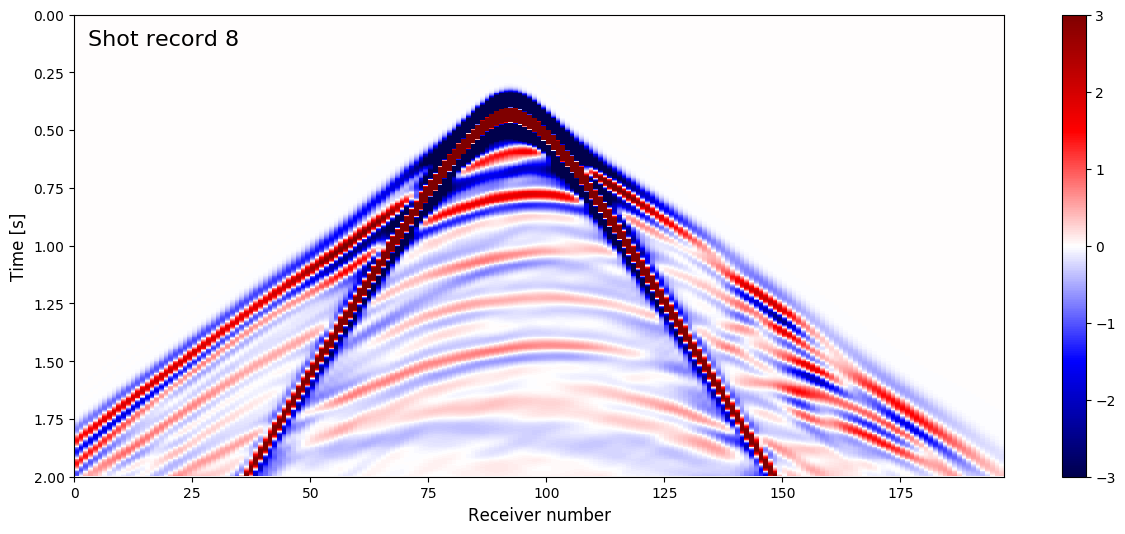

In [4]:
# NOT FOR MANUSCRIPT
using PyPlot

i = 8
figure(figsize=(15,6))
imshow(d_obs.data[i], cmap="seismic", extent=[0,size(d_obs.data[i],2),2,0], aspect=0.3, vmin=-3, vmax=3)
ax1 = gca(); ax1[:set_aspect]("auto")
xlabel("Receiver number", size=12)
ylabel("Time [s]", size=12)
text(3, 0.13, "Shot record $i", size=16)
colorbar()

savefig("../Figures/Figure_1.png", dpi=300)
show()

> **Figure 1**: Observed shot record number 8.

JUDI vectors such as `d_obs` can be used like a regular Julia vectors, so we can compute norms via `norm(d_obs)` or the inner product via `dot(d_obs, d_obs)`, but they contain the shot records in their original dimension. Shot records can be accessed via their respective shot number with `d_obs.data[shot_no]`, while the header information can be accessed with `d_obs.geometry`. We extract the source geometry from our SEG-Y file and then manually set up a source vector `q` with an 8 Hz Ricker wavelet:

In [6]:
f = 0.008  # kHz
src_geom = Geometry(block; key="source")
src_data = ricker_wavelet(src_geom.t[1], src_geom.dt[1], f)
q = judiVector(src_geom, src_data);

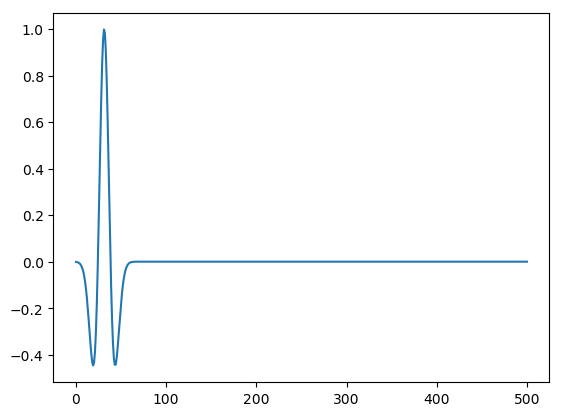

In [7]:
# NOT FOR MANUSCRIPT
plot(q.data[1])
show()

<div style="background: #eeeeee; border: 2px solid gray; border-radius:5px; padding: 6px 10px 6px 10px;">

<h3> NOT FOR MANUSCRIPT</h3>

<p>Since our data set consists of $16$ shot records, both `d_obs` and `q` contain the data and geometries for all source positions. We can check the number of source positions with `d_obs.nsrc` and `q.nsrc` and we can extract the part of the vector that corresponds to one or multiple shots with `d_obs[shot_no], q[shot_no]`. </p>

</div>

We will now set up the forward modeling operator $\mathbf{F}(\mathbf{m},\mathbf{q})$ as a matrix-free operator for the inverse wave equation $\mathbf{A}(\mathbf{m})^{-1}$, where $\mathbf{m}$ is the current model, and source/receiver injection and sampling operators $\mathbf{P}_\mathrm{s}$ and $\mathbf{P}_\mathrm{r}$.

Since the dimensions of the inverse wave equation operator depend on the number of computational time steps, we calculate this number using the `get_computational_nt` function and set up an `info` object that contains some dimensionality information required by all operators.

Then we can define `Pr` and `Ps` as matrix-free operators implementing Devito sparse point injection and interpolation (Louboutin et al., 2017). Multiplications with `Ps` and `Pr` represent sampling the wavefield at source/receiver locations, while their adjoints `Ps', Pr'` denote injecting either source wavelets or shot records into the computational grid.

These projection and modelling operators can then be set up in Julia in the following way:

In [8]:
# NOT FOR MANUSCRIPT
using HDF5

m0, n, d, o = read(h5open("overthrust_model.h5","r"),"m0","n","d","o")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0);

In [9]:
ntComp = get_computational_nt(q.geometry, d_obs.geometry, model0)
info = Info(prod(model0.n), d_obs.nsrc, ntComp)
Pr = judiProjection(info, d_obs.geometry)
Ps = judiProjection(info, q.geometry)
Ainv = judiModeling(info, model0);

The forward modeling step can be expressed mathematically as

$$ F(\mathbf{m};\mathbf{q})=\mathbf{P}_r\mathbf{A}^{-1}(\mathbf{m})\mathbf{P}_s^\top\mathbf{q} $$

which is expressed in Julia as

    d_pred = Pr * Ainv * Ps' * q

This forward models all 16 predicted shot records in parallel. Notice that, in instantiating `Ainv`, we made the wave equation solver implicitly dependent on `model0`.

Finally, we set up the matrix-free Jacobian operator `J` and the Gauss–Newton Hessian `J' * J`. As mentioned in the introduction, `J` is the partial derivative of the forward modeling operator $\mathbf{F}(\mathbf{m}, \mathbf{q})$ with respect to the model `m` and is therefore directly constructed from our modeling operator `Pr * Ainv * Ps'` and a specified source vector `q`:

In [11]:
J = judiJacobian(Pr * Ainv * Ps', q);

<div style="background: #eeeeee; border: 2px solid gray; border-radius:5px; padding: 6px 10px 6px 10px;">

<h3> NOT FOR MANUSCRIPT</h3>

<p>Note that, if we started our Julia session with multiple CPU cores or nodes (`julia -p n`, with `n` being the number of workers), the wave equation solves are automatically parallelized over source locations and all shots are collected in the `d_pred` vector.</p>

<p>We can also model a single or subset of shots by indexing the operators with the respective shot numbers. E.g. if we want to model the first two shots, we define `i=[1,2]` and then run `d_sub = Pr[i]*Ainv[i]*Ps[i]'*q[i]`.</p>

<p>The FWI gradient would then be given by:</p>

<pre style="background: #eeeeee;">
`g = J[i]' * (d_pred - d_obs[i])`
</pre>

<p>If we want to solve an adjoint wave equation with the observed data as the adjoint source and restrictions of the wavefields back to the source locations, we can simply run `qad = Ps * Ainv' * Pr' * d_obs`, exemplifying the advantages of casting FWI in a proper computational linear algebra framework.</p>

<p>Once we have `J` we can also form the Gauss–Newton Hessian:</p>

<pre style="background: #eeeeee;">
`H_GN = J' * J`
</pre>

</div>

In the context of seismic inversion, the Jacobian is also called the linearized modeling or demigration operator and its adjoint `J'` is the migration operator. One drawback of this notation is that the forward wavefields for the gradient calculation have to be recomputed, since the forward modeling operator only returns the shot records and not the complete wavefields. For this reason, JUDI has an additional function for computing the gradients of the FWI objective function `f,g = fwi_objective(model0,q[i],d_obs[i])`, which takes the current model, source and data vectors as an input and computes the objective value and gradient in parallel without having to recompute the forward wavefields.


## FWI via gradient descent

With expressions for modeling operators, Jacobians and gradients of the FWI objective, we can now implement different FWI algorithms in a few lines of code. We will start with a basic gradient descent example with a line search. To reduce the computational cost of full gradient descent, we will use a stochastic approach in which we only compute the gradient and function value for a randomized subset of source locations. In JUDI, this is accomplished by choosing a random vector of integers between 1 and 16 and indexing the data vectors as described earlier. Furthermore, we will apply a projection operator `proj(x)`, which prevent velocities (or squared slownesses) becoming negative or too large by clipping values outside the allowed range.

A few extra variables are defined in the notebook, but the full algorithm for FWI with stochastic gradient descent and box constraints is implemented as follows:

In [12]:
# NOT FOR MANUSCRIPT
# Set up bound constraints.
v0 = sqrt.(1f0./model0.m)
vmin = ones(Float32, model0.n)*1.3f0
vmax = ones(Float32, model0.n)*6.5f0

# Fix water column.
vmin[:,1:21] = v0[:,1:21]
vmax[:,1:21] = v0[:,1:21]

# Convert to squared slowness.
mmin = vec((1f0./vmax).^2)
mmax = vec((1f0./vmin).^2);

In [13]:
# NOT FOR MANUSCRIPT
maxiter = 10
batchsize = 8    # Number of shots for each iteration.
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)], 2), model0.n)
fhistory_SGD = zeros(Float32, maxiter);

In [14]:
for j=1:maxiter
    # FWI objective function value and gradient.
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, grad = fwi_objective(model0, q[i], d_obs[i])
    fhistory_SGD[j] = fval  # OMIT LINE FROM MANUSCRIPT

    # Line search and update model.
    update = backtracking_linesearch(model0,
                                     q[i],
                                     d_obs[i],
                                     fval,
                                     grad,
                                     proj;
                                     alpha=1f0)
    model0.m += reshape(update, model0.n)

    # Apply box constraints.
    model0.m = proj(model0.m)
end

In [15]:
# NOT FOR MANUSCRIPT
model_SGD = copy(model0.m);

JUDI's `backtracking_linesearch` function performs an approximate line search and returns a model update that leads to a decrease of the objective function value (Armijo condition; Nocedal and Wright, 2009). The result after 10 iterations of SGD with box constraints is shown in Figure 2. In practice, where starting models are typically less accurate than in our example, FWI is often performed from low to high frequencies, since the objective function has less local minima for lower frequencies (Bunks et al., 1995). In this multi-scale FWI approach, a low-pass filtered version of the data is used to invert for a low resolution velocity model first and higher frequencies are added in subsequent iterations.

## FWI via the Gauss–Newton method

As discussed earlier, the convergence rate of GD depends on the objective function, but requires many FWI iterations necessary to reach an acceptable solution. Using our matrix-free operator for the Jacobian J, we can modify the above code to implement the Gauss–Newton method (Equation 3) to improve the convergence rate. In practice, directly inverting the Gauss–Newton Hessian `J'* J` should be avoided, because the matrix is badly conditioned and takes many iterations to invert. Instead, we perform a few iterations of a least-squares solver, `lsqr()`, to approximately solve `J * p = d_pred - d_obs` and obtain the update direction `p`. `lsqr`,  from the Julia `IterativeSolvers` package, is a conjugate-gradient type algorithm for solving least squares problems and is mathematically equivalent to inverting `J' * J`, but has better numerical properties (Paige and Saunders, 1982). We implement the Gauss-Newton method as follows:

In [16]:
# NOT FOR MANUSCRIPT
model0.m = m0    # Reset velocity model.
fhistory_GN = zeros(Float32,maxiter);

In [17]:
using IterativeSolvers

DO NOT RUN BY ACCIDENT  # OMIT LINE FROM MANUSCRIPT

for j=1:maxiter
    # Model predicted data.
    d_pred = Pr * Ainv * Ps' * q

    # GN update direction.
    p = lsqr(J, d_pred - d_obs; maxiter=6)
    fhistory_GN[j] = .5f0 * norm(d_pred - d_obs)^2  # OMIT LINE FROM MANUSCRIPT

    # update model and box constraints.
    model0.m = model0.m - reshape(p, model0.n)
end

<div style="background: #eeeeee; border: 2px solid gray; border-radius:5px; padding: 6px 10px 6px 10px;">

<h3> NOT FOR MANUSCRIPT</h3>

<p>An important benefit of matrix-free operators is that we do not need to implement our own least-squares solver, but can pass `J` and the data residual `d_pred - d_obs` to a third-party optimization library. The operator `J` does not need to be an explicit matrix, since `lsqr` only uses matrix-vector products. </p>

</div>

In contrast to our SGD algorithm, we use all shot records in every iteration, since stochastic methods for second order algorithms are less well understood, making this approach considerably more expensive than our previous algorithm. However, as shown in figures 2 and 3, it achieves a superior result, with a considerably lower misfit compared to the known model. Furthermore, figure 3 shows that it achieves the improved result in relatively few iterations.

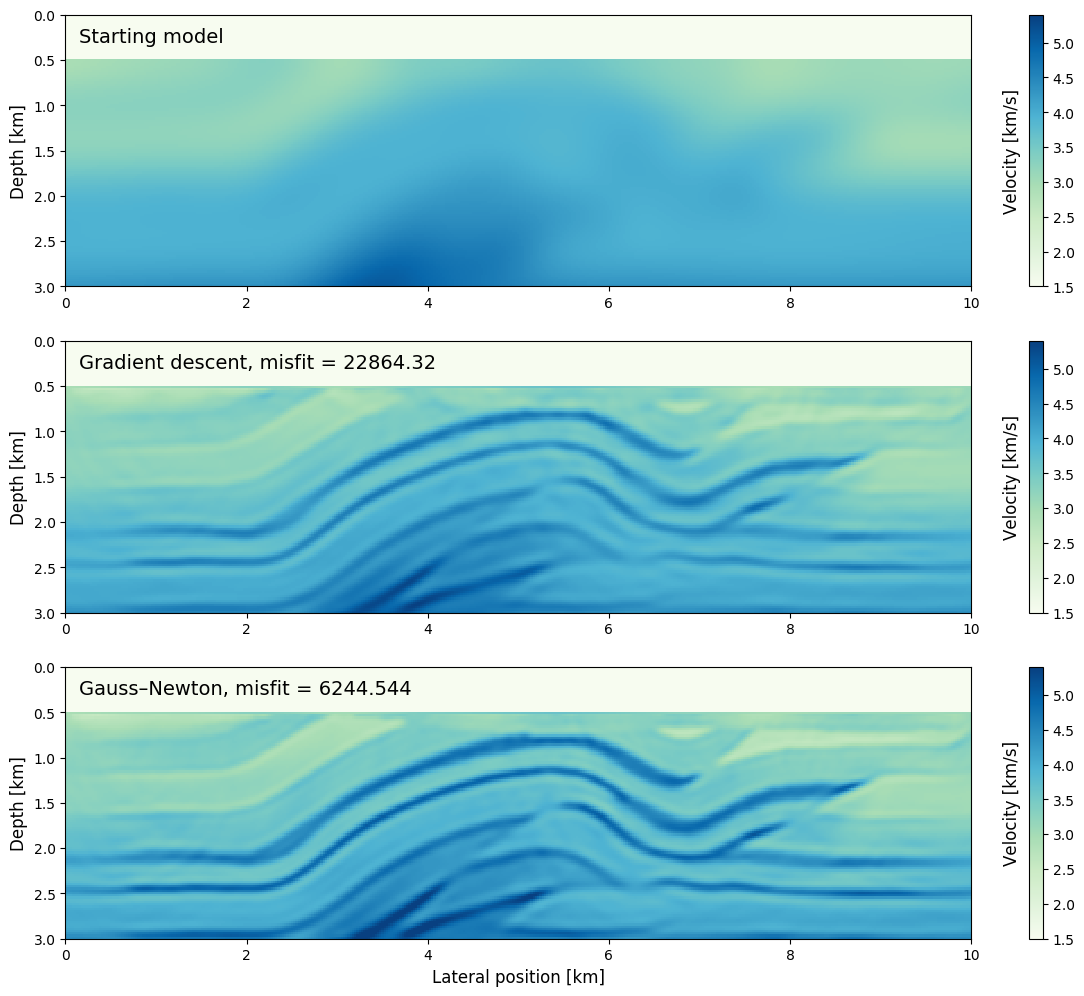

In [18]:
# NOT FOR MANUSCRIPT
figure(figsize=(15, 12))

subplot(311)
imshow(sqrt.(1f0./m0)', cmap="GnBu", extent=(0,10,3,0), vmin=1.5, vmax=5.4)
text(0.15, 0.3, "Starting model", size=14, color="black")
ylabel("Depth [km]", size=12)
colorbar()
text(10.35, 1.5, "Velocity [km/s]", va="center", size=12, rotation=90)

subplot(312)
imshow(sqrt.(1f0./model_SGD)', cmap="GnBu", extent=(0,10,3,0), vmin=1.5, vmax=5.4)
misfit = round(fhistory_SGD[end], 3)
text(0.15, 0.3, "Gradient descent, misfit = $misfit", size=14, color="black")
ylabel("Depth [km]", size=12)
colorbar()
text(10.35, 1.5, "Velocity [km/s]", va="center", size=12, rotation=90)

subplot(313)
imshow(sqrt.(1f0./model0.m)', cmap="GnBu", extent=(0,10,3,0), vmin=1.5, vmax=5.4)
misfit = round(fhistory_GN[end], 3)
text(0.15, 0.3, "Gauss–Newton, misfit = $misfit", size=14, color="black")
xlabel("Lateral position [km]", size=12)
ylabel("Depth [km]", size=12)
colorbar()
text(10.35, 1.5, "Velocity [km/s]", va="center", size=12, rotation=90)

savefig("../Figures/Figure_2.png", dpi=300)
show()

> **Figure 2**: (a) Initial model. (b) Recovered velocity model after 10 iterations of stochastic gradient descent with box constraints and a batch size of 8 shots. (c) Recovered velocity model after 10 iterations of the Gauss–Newton method, with 6 iterations of `LSQR` for the Gauss–Newton subproblem, and using all shots in every iteration. The resulting misfit is substantially lower that what was achieved with gradient descent.

In [19]:
# NOT FOR MANUSCRIPT
fhistory_SGD = fhistory_SGD/norm(fhistory_SGD, Inf)
fhistory_GN = fhistory_GN/norm(fhistory_GN, Inf);

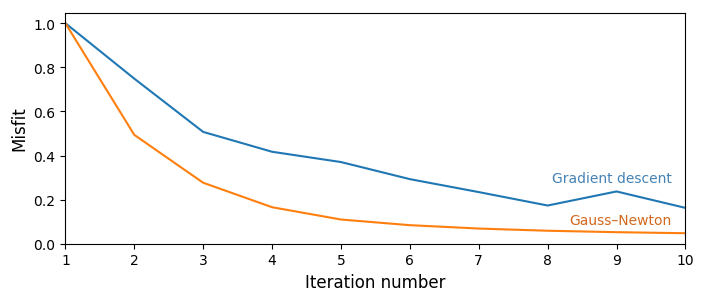

In [24]:
# NOT FOR MANUSCRIPT
figure(figsize=(8,3))
plot(1:10, fhistory_SGD, label="Gradient descent")
plot(1:10, fhistory_GN, label="Gauss–Newton")
text(9.8, 0.28, "Gradient descent", ha="right", color="steelblue")
text(9.8, 0.09, "Gauss–Newton", ha="right", color="chocolate")
xlabel("Iteration number", size=12)
ylabel("Misfit", size=12)
xlim(1, 10)

savefig("../Figures/Figure_3.png", dpi=300)
show()

> **Figure 3**: Normalized function values for the FWI inversion example with stochastic gradient descent and the Gauss-Newton method.

An alternative to (Gauss–)Newton methods are quasi-Newton methods, which build up an approximation of the Hessian from previous gradients only and require no additional PDE solves or matrix inversions. Implementing an efficient and correct version of this method, such as the L-BFGS algorithm, exceeds a few lines of code and we therefore leave this exercise to the reader. Instead of implementing more complicated algorithms by hand, it is also possible to interface third-party Julia optimization libraries and an example for this is given in the notebook **fwi_example_NLopt.ipynb**.

Even though all examples shown here are two-dimensional, in order to make them reproducible on a laptop or desktop PC, JUDI can be used for 3D modeling and inversion without having to change the code, since the number of dimensions are automatically inferred from the velocity model and data dimensions.


## Conclusions

In this final part of our FWI tutorial series, we demonstrated how to set up basic optimization algorithms for waveform inversion using JUDI. The methods shown here are all gradient based and differ in the way how update directions for the velocity model are computed. Our numerical examples can serve for the reader as a basis for developing more advanced FWI workflows, which usually include additional data preprocessing, frequency continuation techniques or further model constraints.



## Acknowledgments

This research was carried out as part of the SINBAD II project with the support of the member organizations of the SINBAD Consortium. This work was financially supported in part by EPSRC grant EP/L000407/1 and the Imperial College London Intel Parallel Computing Centre.


## References

Aminzadeh, F., Brac, J., and Kunz, T., 1997. 3D Salt and Overthrust models. SEG/EAGE Modeling Series, No. 1: Distribution CD of Salt and Overthrust models, SEG Book Series Tulsa, Oklahoma.

Bezanson, J., Karpinski, S., Shah, V. B., and Edelman, A., 2012, Julia: A fast dynamic language for technical computing: CoRR. Retrieved from http://arxiv.org/abs/1209.5145

Bunks, C., Saleck, F. M., Zaleski, S., and Chavent, G., 1995, Multiscale seismic waveform inversion: GEOPHYSICS, 60, 1457–1473. doi:10.1190/1.1443880

Johnson, S., 2017, Calling python functions from the julia language: GitHub repository. https://github.com/JuliaPy/PyCall.jl; GitHub.

Lange, M., Kukreja, N., Louboutin, M., Luporini, F., Zacarias, F. V., Pandolfo, V., … Gorman, G., 2016, Devito: Towards a generic finite difference DSL using symbolic python: 6th workshop on python for high-performance and scientific computing. doi:10.1109/PyHPC.2016.9

Leeuwen, T. van, Aravkin, A. Y., Calandra, H., and Herrmann, F. J., 2013, In which domain should we measure the misfit for robust full waveform inversion? EAGE annual conference proceedings. doi:10.3997/2214-4609.20130839

Louboutin, M., Witte, P. A., Lange, M., Kukreja, N., Luporini, F., Gorman, G., and Herrmann, F. J., 2017, Full-waveform inversion - part 1: Forward modeling: Retrieved from https://www.slim.eos.ubc.ca/Publications/Private/Submitted/2017/louboutin2017fwi/louboutin2017fwi.html

Louboutin, M., Witte, P. A., Lange, M., Kukreja, N., Luporini, F., Gorman, G., and Herrmann, F. J., 2018, Full-waveform inversion - part 2: Adjoint modeling:

Nocedal, J., and Wright, S., 2009, Numerical optimization: (2nd ed.). Springer.

Paige, C. C., and Saunders, M. A., 1982, LSQR: An algorithm for sparse linear equations and sparse least squares: ACM Trans. Math. Softw., 8, 43–71. doi:10.1145/355984.355989

Peters, B., and Herrmann, F. J., 2017, Constraints versus penalties for edge-preserving full-waveform inversion: The Leading Edge, 36, 94–100. doi:10.1190/tle36010094.1

Warner, M., and Guasch, L., 2014, Adaptive waveform inversion: Theory: In SEG technical program expanded abstracts 2014 (pp. 1089–1093). doi:10.1190/segam2014-0371.1